<a href="https://colab.research.google.com/github/sparks-baird/xtal2png/blob/main/notebooks/3.1-imagen-pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using `xtal2png` with `imagen-pytorch`

In [1]:
%pip install mp-time-split xtal2png imagen-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 40.6 MB 2.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.4 MB 32.0 MB/s 
     |████████████████████████████████| 561 kB 65.2 MB/s 
     |████████████████████████████████| 79.9 MB 1.2 MB/s 
     |████████████████████████████████| 117 kB 75.9 MB/s 
     |████████████████████████████████| 314 kB 72.7 MB/s 
     |████████████████████████████████| 1.2 MB 51.7 MB/s 
     |████████████████████████████████| 4.4 MB 58.9 MB/s 
     |████████████████████████████████| 80 kB 6.5 MB/s 
     |████████████████████████████████| 5.2 MB 50.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel met

In [2]:
from os import path
from uuid import uuid4
from tqdm import tqdm
import math

import numpy as np
import torch
from imagen_pytorch import Imagen, ImagenTrainer, SRUnet256, BaseUnet64, Unet
from mp_time_split.core import MPTimeSplit

from xtal2png.core import XtalConverter

Downloading:   0%|          | 0.00/605 [00:00<?, ?B/s]

## Data and `xtal2png` images

In [3]:
dummy = True #@param {type:"boolean"}
max_batch_size = 32 #@param {type:"integer"}
# `max_batch_size` suggested by lucidrains to be at least 32

mpt = MPTimeSplit()
mpt.load(dummy=dummy)

fold = 0
train_inputs, val_inputs, train_outputs, val_outputs = mpt.get_train_and_val_data(fold)

xc = XtalConverter(encode_as_primitive=True, decode_as_primitive=True)
arrays, _, _ = xc.structures_to_arrays(train_inputs.tolist(), rgb_scaling=False)
training_images = torch.from_numpy(arrays).float().cuda()

Reading file /usr/local/lib/python3.7/dist-packages/mp_time_split/utils/mp_dummy_time_summary.json.gz: 0it [00:00, ?it/s]
Decoding objects from /usr/local/lib/python3.7/dist-packages/mp_time_split/utils/mp_dummy_time_summary.json.gz: 100%|##########| 11/11 [00:00<00:00, 263.34it/s]
100%|██████████| 3/3 [00:00<00:00, 15.94it/s]


## Training

In [4]:
if dummy:
  timesteps = 10
  epochs = 3
  checkpoint_rate = 2
else:
  timesteps = 1000 #@param {type:"integer"}
  epochs = 10000 #@param {type:"integer"}
  checkpoint_rate = 500 #@param {type:"integer"}

# unets for unconditional imagen
unet1 = Unet(
    dim=32,
    dim_mults=(1, 2, 4),
    num_resnet_blocks=3,
    layer_attns=(False, True, True),
    layer_cross_attns=(False, True, True),
    use_linear_attn=True,
)

# see also SRUnet256
unet2 = Unet(
    dim=128,
    dim_mults = (1, 2, 4, 8),
    num_resnet_blocks = (2, 4, 8, 8),
    layer_attns = (False, False, False, True),
    layer_cross_attns = (False, False, False, True),
    attn_heads = 8,
    ff_mult = 2.,
    memory_efficient = True,
    # use_linear_attn=True,
)

# imagen, which contains the unets above
imagen = Imagen(
    condition_on_text=False,  # this must be set to False for unconditional Imagen
    unets=(unet1, unet2),
    channels=1,
    image_sizes=(32, 64),
    timesteps=timesteps,
)

trainer = ImagenTrainer(imagen).cuda()

results_folder = path.join(
    "data", "interim", "imagen-pytorch", f"fold={fold}", str(uuid4())[0:4]
)

# capture the tqdm output (which keeps printing newlines) to avoid Colab crash
from IPython.utils import io
# train each unet in concert, or separately (recommended) to completion
l_arr = [[],[]]
for u in (1, 2):
  with tqdm(total=epochs) as pbar:
    for epoch in range(epochs):
      with io.capture_output() as captured:
        loss = trainer(training_images, unet_number=u, max_batch_size=max_batch_size)
        trainer.update(unet_number=u)
      l_arr[u-1].append(loss)
      trainer.save(f'./checkpoint/checkpoint_{u}_{epoch}.pt')
      pbar.update()
    if epoch % checkpoint_rate == 0 and not math.isnan(loss):
      trainer.save(results_folder + f"_{epoch}.pt")

The base dimension of your u-net should ideally be no smaller than 128, as recommended by a professional DDPM trainer https://nonint.com/2022/05/04/friends-dont-let-friends-train-small-diffusion-models/
The base dimension of your u-net should ideally be no smaller than 128, as recommended by a professional DDPM trainer https://nonint.com/2022/05/04/friends-dont-let-friends-train-small-diffusion-models/


100%|██████████| 3/3 [00:40<00:00, 13.58s/it]


## Sampling

In [ ]:
with io.capture_output() as captured:
  images = trainer.sample(batch_size=16, return_pil_images=True)
  trainer.save(results_folder + "_end.pt")

## Visualization

In [5]:
from PIL import Image
def image_grid(imgs, rows, cols):
    """https://stackoverflow.com/questions/37921295/python-pil-image-make-3x3-grid-from-sequence-images
    https://stackoverflow.com/a/65583584/13697228
    """
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

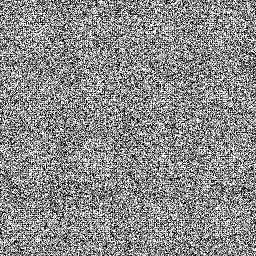

In [6]:
image_grid(images, 4, 4)